<a href="https://colab.research.google.com/github/YuHsin-Chen1221/Medical-Diagnosis-Models/blob/main/Brain_Tumor_Segmentation_with_U_Net_(final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation

Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown
 85% 264M/312M [00:00<00:00, 1.39GB/s]
100% 312M/312M [00:00<00:00, 1.38GB/s]


In [ ]:
!unzip /content/brain-tumor-segmentation.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: images/2013.png         
  inflating: images/2014.png         
  inflating: images/2015.png         
  inflating: images/2016.png         
  inflating: images/2017.png         
  inflating: images/2018.png         
  inflating: images/2019.png         
  inflating: images/202.png          
  inflating: images/2020.png         
  inflating: images/2021.png         
  inflating: images/2022.png         
  inflating: images/2023.png         
  inflating: images/2024.png         
  inflating: images/2025.png         
  inflating: images/2026.png         
  inflating: images/2027.png         
  inflating: images/2028.png         
  inflating: images/2029.png         
  inflating: images/203.png          
  inflating: images/2030.png         
  inflating: images/2031.png         
  inflating: images/2032.png         
  inflating: images/2033.png         
  inflating: images/2034.png         
  inflating: images/2035.png         
  inflating: images/2036.png 

In [ ]:
# files reading & data proprocessing

import os
import cv2
import numpy as np

IMG_SIZE = 128
img_dir = "/content/images"
mask_dir = "/content/masks"

image_filenames = sorted(os.listdir(img_dir))
mask_filenames = sorted(os.listdir(mask_dir))

images = []
masks = []

for img_name, mask_name in zip(image_filenames, mask_filenames):
    # 讀取影像與 mask
    img = cv2.imread(os.path.join(img_dir, img_name), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)

    # Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

    # Normalize image to [0, 1]
    img = img / 255.0

    # Binarize mask (0 or 1)
    mask = (mask > 127).astype(np.uint8)

    images.append(img)
    masks.append(mask)

X = np.expand_dims(np.array(images), axis=-1)
y = np.expand_dims(np.array(masks), axis=-1)

print("Image shape:", X.shape)
print("Mask shape:", y.shape)

Image shape: (3064, 128, 128, 1)
Mask shape: (3064, 128, 128, 1)


In [ ]:
# data splitting

from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

Train: (2144, 128, 128, 1)
Val:   (460, 128, 128, 1)
Test:  (460, 128, 128, 1)


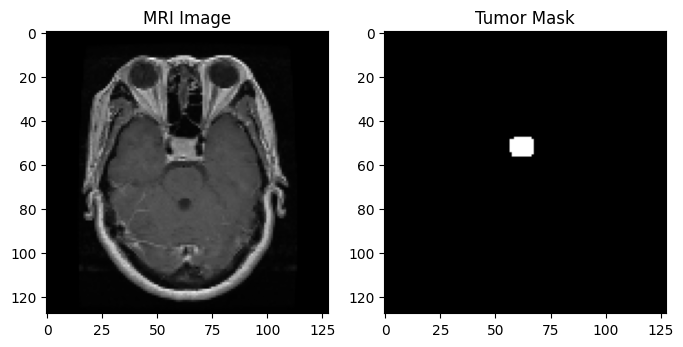

In [ ]:
# visualization
import matplotlib.pyplot as plt

def show_sample(index=0):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(X[index, :, :, 0], cmap='gray')
    axs[0].set_title("MRI Image")
    axs[1].imshow(y[index, :, :, 0], cmap='gray') # Changed 'black' to 'gray'
    axs[1].set_title("Tumor Mask")
    plt.show()

show_sample(10)

In [ ]:
# CNN Model

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose
from tensorflow.keras.models import Sequential

layers = [
    Conv2D(input_shape=[256, 256, 1],
           filters=100,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=200,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=2,
           kernel_size=1,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2DTranspose(filters=2, kernel_size=31, strides=16, padding="same")
]

model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 100s 365ms/step - accuracy: 0.9183 - loss: 0.2119 - val_accuracy: 0.9826 - val_loss: 0.0642
Epoch 2/10
187/268 ━━━━━━━━━━━━━━━━━━━━ 25s 312ms/step - accuracy: 0.9827 - loss: 0.0644

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 128, 128, 100)  │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 32, 32, 200)    │       500,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 16, 16, 300)    │       540,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 16, 16, 300)    │       810,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 16, 16, 2)      │           602 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 256, 256, 2)    │         3,846 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,573,546 (21.26 MB)

 Trainable params: 1,857,848 (7.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,715,698 (14.17 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


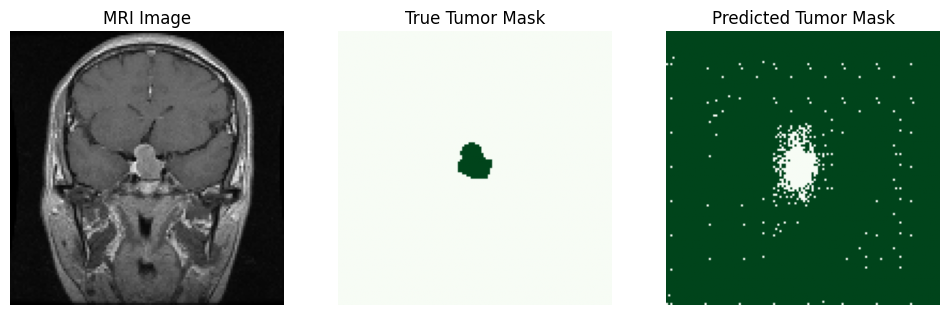

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


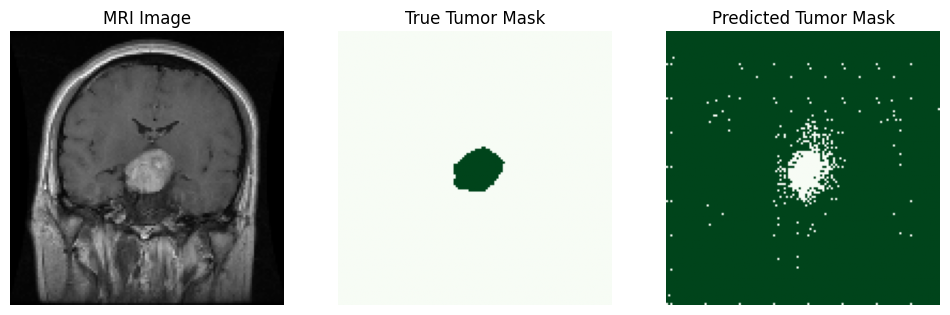

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


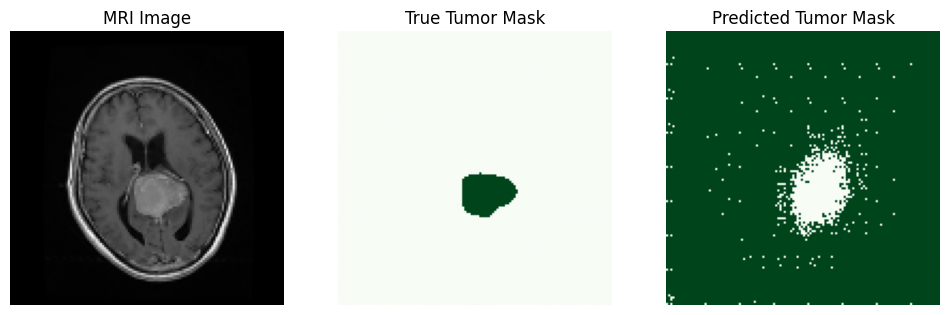

In [ ]:
# Visualize some predictions
import random

def show_prediction(index):
    img = X_test[index]
    true_mask = y_test[index]
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0] # Predict on a single image

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(img[:, :, 0], cmap='gray')
    axs[0].set_title("MRI Image")
    axs[0].axis('off')

    axs[1].imshow(true_mask[:, :, 0], cmap='gray')
    axs[1].set_title("True Tumor Mask")
    axs[1].axis('off')

    # Apply a threshold to the predicted mask for visualization
    pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)
    axs[2].imshow(pred_mask_binary[:, :, 0], cmap='gray')
    axs[2].set_title("Predicted Tumor Mask")
    axs[2].axis('off')

    plt.show()

# Show a few random predictions
for _ in range(3):
    index = random.randint(0, len(X_test) - 1)
    show_prediction(index)

### Finish task
The model has been trained and evaluated. The next steps would be to potentially refine the model architecture, hyperparameters, or training data to improve performance further, or to deploy the model for inference on new data.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class BrainTumorDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Convert numpy arrays to PyTorch tensors and ensure correct dimensions (C, H, W)
        # The original numpy arrays have shape (H, W, C), so we need to transpose
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).permute(2, 0, 1).float()

        return image, mask

# Create Dataset instances
train_dataset = BrainTumorDataset(X_train, y_train)
val_dataset = BrainTumorDataset(X_val, y_val)
test_dataset = BrainTumorDataset(X_test, y_test)

# Create DataLoader instances
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Number of batches in training DataLoader:", len(train_dataloader))
print("Number of batches in validation DataLoader:", len(val_dataloader))
print("Number of batches in test DataLoader:", len(test_dataloader))

Number of batches in training DataLoader: 268
Number of batches in validation DataLoader: 58
Number of batches in test DataLoader: 58


## Define loss function and optimizer

### Subtask:
Choose an appropriate loss function and optimizer for the PyTorch U-Net model.


In [ ]:
# unet_pytorch.py
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------- building blocks ----------

class ConvNormAct(nn.Sequential):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1, norm=nn.BatchNorm2d, act=nn.ReLU):
        super().__init__(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=False),
            norm(out_ch),
            act(inplace=True)
        )

class ResidualUnit(nn.Module):
    """
    2×(Conv->BN->ReLU) with residual skip. If channels differ, uses 1x1 to match.
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = ConvNormAct(in_ch, out_ch, k=3, s=1, p=1)
        self.conv2 = ConvNormAct(out_ch, out_ch, k=3, s=1, p=1)
        self.skip = nn.Identity() if in_ch == out_ch else nn.Conv2d(in_ch, out_ch, 1, bias=False)

    def forward(self, x):
        identity = self.skip(x)
        out = self.conv1(x)
        out = self.conv2(out)
        return F.relu(out + identity, inplace=True)

class DownBlock(nn.Module):
    """
    Optional downsample (stride-2 conv) then num_res_units residual units.
    """
    def __init__(self, in_ch, out_ch, num_res_units=2, down=True):
        super().__init__()
        layers = []
        if down:
            layers.append(ConvNormAct(in_ch, out_ch, k=3, s=2, p=1))  # downsample
        else:
            # first stage, no spatial downsample; just lift channels
            if in_ch != out_ch:
                layers.append(ConvNormAct(in_ch, out_ch, k=3, s=1, p=1))
        for _ in range(num_res_units):
            layers.append(ResidualUnit(out_ch, out_ch))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class UpBlock(nn.Module):
    """
    Up-conv -> concat skip -> num_res_units residual units.
    """
    def __init__(self, in_ch, out_ch, num_res_units=2):
        super().__init__()
        # in_ch: channels coming from the lower (decoder) level
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.fuse = nn.Conv2d(out_ch*2, out_ch, kernel_size=1)  # compress after concat
        self.ru = nn.Sequential(*[ResidualUnit(out_ch, out_ch) for _ in range(num_res_units)])

    def forward(self, x, skip):
        x = self.up(x)
        # handle odd shapes due to rounding (shouldn't happen with powers of 2, but just in case)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = F.relu(self.fuse(x), inplace=True)
        return self.ru(x)

# ---------- full UNet ----------

class UNet2D(nn.Module):
    """
    PyTorch UNet mirroring MONAI UNet config:
    - spatial_dims=2
    - channels=(16,32,64,128,256)
    - strides=(2,2,2,2)
    - num_res_units=2
    Returns logits (no softmax/sigmoid).
    """
    def __init__(self, in_channels=1, out_channels=2,
                 channels=(16, 32, 64, 128, 256),
                 strides=(2, 2, 2, 2),
                 num_res_units=2):
        super().__init__()
        assert len(channels) >= 2
        assert len(strides) == len(channels) - 1  # 4 strides for 5 channel stages

        # Encoder
        self.enc = nn.ModuleList()
        ch_in = in_channels
        for i, ch_out in enumerate(channels):
            down = (i != 0)
            self.enc.append(DownBlock(ch_in, ch_out, num_res_units=num_res_units, down=down))
            ch_in = ch_out

        # Decoder
        self.dec = nn.ModuleList()
        for i in range(len(channels) - 1, 0, -1):
            self.dec.append(UpBlock(channels[i], channels[i-1], num_res_units=num_res_units))

        # Head
        self.head = nn.Conv2d(channels[0], out_channels, kernel_size=1)

    def forward(self, x):
        skips = []
        # Encoder forward; collect skip features
        for i, block in enumerate(self.enc):
            x = block(x)
            skips.append(x)
        # Bottleneck feature is last in skips
        x = skips.pop()  # deepest

        # Decoder with skips in reverse (excluding deepest which we popped)
        for up, skip in zip(self.dec, reversed(skips)):
            x = up(x, skip)

        return self.head(x)  # logits


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet2D(
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),   # encoded in the DownBlock via stride-2 convs
    num_res_units=2
).to(device)


In [ ]:

class DiceLossMulticlass(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        """
        logits: (N, C, H, W)
        targets: (N, H, W) 或 (N, 1, H, W) with class indices
        """
        if targets.ndim == 4 and targets.shape[1] == 1:
            targets = targets.squeeze(1)  # (N, H, W)

        probs = F.softmax(logits, dim=1)
        one_hot = torch.zeros_like(probs).scatter_(1, targets.unsqueeze(1).long(), 1.0)

        dims = (0, 2, 3)
        intersect = torch.sum(probs * one_hot, dims)
        denom = torch.sum(probs, dims) + torch.sum(one_hot, dims)
        dice_per_class = (2 * intersect + self.smooth) / (denom + self.smooth)
        return 1.0 - dice_per_class.mean()

criterion = DiceLossMulticlass()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
model.train()
for epoch in range(10): # Increased epochs for demonstration
    running_loss = 0.0
    running_correct_pixels = 0
    running_total_pixels = 0
    for images, masks in train_dataloader:
        optimizer.zero_grad()
        # Move batch data to device
        images = images.to(device)
        masks = masks.to(device)

        logits = model(images)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0) # Accumulate loss

        # Calculate training accuracy
        predicted_masks = torch.argmax(logits, dim=1) # Get predicted class for each pixel
        correct_pixels = (predicted_masks == masks.squeeze(1)).sum().item() # Compare with true masks (remove channel dim from true masks)
        total_pixels = masks.numel() # Total number of pixels in the batch
        running_correct_pixels += correct_pixels
        running_total_pixels += total_pixels


    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_accuracy = running_correct_pixels / running_total_pixels

    print(f"epoch {epoch+1}: loss={epoch_loss:.4f}, acc={epoch_accuracy:.4f}")

epoch 1: loss=0.1539, acc=0.9904
epoch 2: loss=0.1406, acc=0.9911
epoch 3: loss=0.1337, acc=0.9916
epoch 4: loss=0.1266, acc=0.9920
epoch 5: loss=0.1184, acc=0.9926
epoch 6: loss=0.1102, acc=0.9930
epoch 7: loss=0.0990, acc=0.9937
epoch 8: loss=0.0973, acc=0.9938
epoch 9: loss=0.0952, acc=0.9940
epoch 10: loss=0.0933, acc=0.9941


In [ ]:
model.eval()

UNet2D(
  (enc): ModuleList(
    (0): DownBlock(
      (net): Sequential(
        (0): ConvNormAct(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ResidualUnit(
          (conv1): ConvNormAct(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (conv2): ConvNormAct(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (skip): Identity()
        )
        (2): ResidualUnit(
          (conv1): ConvNormAct(


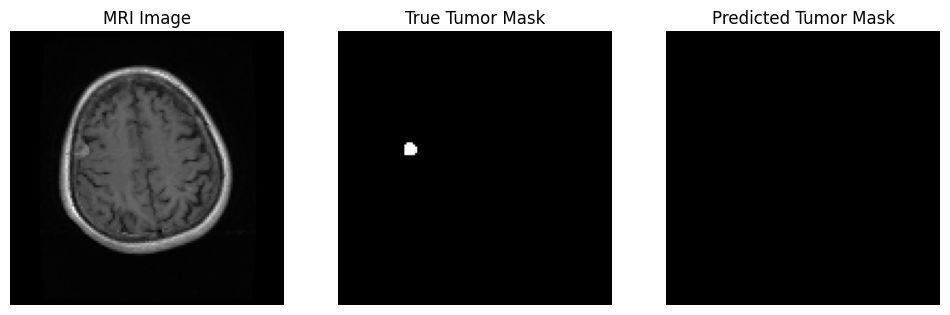

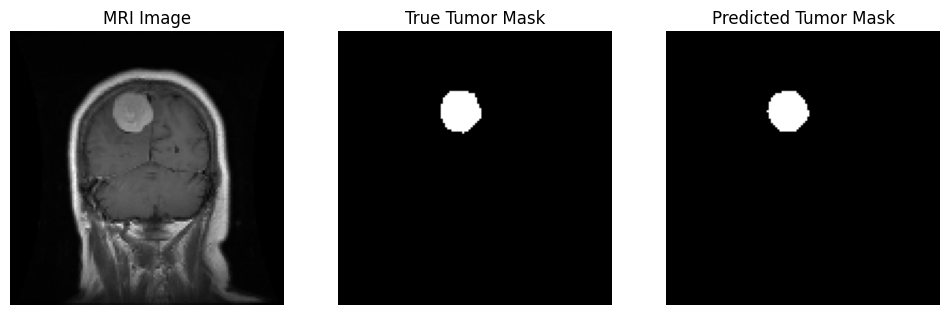

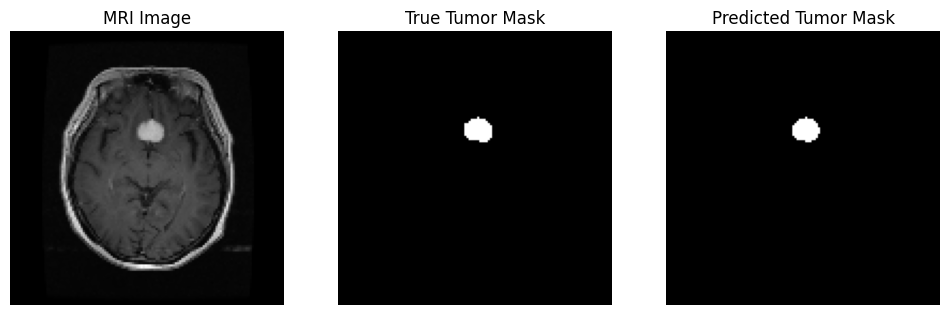

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch

def show_pytorch_prediction(index):
    # Retrieve image and true mask from the test dataset
    img, true_mask = test_dataset[index]

    # Move image to the same device as the model for prediction
    img = img.to(device)

    # Set model to evaluation mode
    model.eval()

    # Get prediction
    with torch.no_grad():
        # Add a batch dimension (PyTorch models expect a batch)
        img_batch = img.unsqueeze(0)
        pred_mask_output = model(img_batch) # Output shape: (1, 2, H, W)

    # Apply softmax to get probabilities, then select the tumor channel (index 1)
    pred_probs = torch.softmax(pred_mask_output, dim=1) # Shape: (1, 2, H, W)
    pred_tumor_channel = pred_probs[:, 1, :, :] # Select tumor channel (index 1), Shape: (1, H, W)

    # Apply threshold to get binary mask, remove batch dimension, move to CPU, and convert to numpy
    pred_mask_binary = (pred_tumor_channel > 0.5).squeeze(0).cpu().numpy().astype(np.uint8) # Shape: (H, W)


    # Move true mask to CPU and remove channel dimension for visualization
    # The true mask might have shape (1, H, W) from the dataset
    true_mask = true_mask.squeeze(0).cpu().numpy() # Shape: (H, W)


    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Display original MRI image (move to CPU and remove channel dimension for imshow)
    axs[0].imshow(img.squeeze(0).cpu().numpy(), cmap='gray') # Shape: (H, W)
    axs[0].set_title("MRI Image")
    axs[0].axis('off')

    # Display true tumor mask
    axs[1].imshow(true_mask, cmap='gray') # Shape: (H, W)
    axs[1].set_title("True Tumor Mask")
    axs[1].axis('off')

    # Display predicted tumor mask
    axs[2].imshow(pred_mask_binary, cmap='gray') # Shape: (H, W)
    axs[2].set_title("Predicted Tumor Mask")
    axs[2].axis('off')

    plt.show()

# Show a few random predictions
for _ in range(3):
    index = random.randint(0, len(test_dataset) - 1)
    show_pytorch_prediction(index)